In [129]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.ndimage.filters import gaussian_filter

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

# From https://github.com/rhayman/ephysiopy
from ephysiopy.common.gridcell import SAC


%load_ext autoreload
%autoreload 2

# sns.set_style("ticks")
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [428]:
def generate_ratemap_from_activations(neuron_activation, positions, num_bins=25, smoothing=1, max_pos=None):
    """
    Generates ratemap for given neuron_activations and positions. Every value in positions has a corresponding neuron_activation
    """
    # If not square make bins square and use unequal amount of bins
    if max_pos is None:
        max_pos = np.max(positions, axis=0)
    if np.argmax(max_pos) == 0:
        square_bins = [num_bins, int(num_bins * (max_pos[0] / max_pos[1]))]
    else:
        square_bins = [int(num_bins * (max_pos[1] / max_pos[0])), num_bins]

    # 1.) Calculate occupancy and activty
    heatmap_occupancy, xedges, yedges = np.histogram2d(
        positions[:, 1], positions[:, 0], bins=square_bins, normed=False)
    heatmap_activity, xedges, yedges = np.histogram2d(positions[:, 1], positions[:, 0], bins=(
        xedges, yedges), normed=False, weights=neuron_activation)
    # 2.) Calculate rate map as AVERAGE
    ratemap = heatmap_activity / heatmap_occupancy
    # 2.1) Smooth ratemap TAKE GOOD CARE OF NANS
    # see here (https://stackoverflow.com/questions/18697532/gaussian-filtering-a-image-with-nan-in-python)
    V = ratemap.copy()
    V[ratemap!=ratemap] = 0
    VV = gaussian_filter(V, sigma=smoothing)

    W = 0 * ratemap.copy() + 1
    W[ratemap!=ratemap] = 0
    WW = gaussian_filter(W, sigma=smoothing)

    ratemap_wo_nan = VV / WW
    ratemap_wo_nan[ratemap_wo_nan!=ratemap_wo_nan] = 0

    ratemap_with_nan = ratemap_wo_nan.copy()
    ratemap_with_nan[ratemap!=ratemap] = np.NaN
    # 3.) Return with edges
    return (ratemap, ratemap_with_nan, ratemap_wo_nan, xedges, yedges)

def get_spikes_across_experiment(actual_spike_times, traj_times):
    # Impossible to get slower than this
    spike_times = np.zeros((len(traj_times)))
    for i in range(0, len(actual_spike_times)):
        argmin = np.argmin(abs(traj_times - actual_spike_times[i]))
        spike_times[argmin] += 1
    return spike_times

def get_spikes_across_experiment_faster(actual_spike_times, traj_times):
    interp_spikes = np.interp(actual_spike_times, traj_times, np.arange(0, len(traj_times)))
    spike_times = np.bincount(interp_spikes.astype(int))
    spike_times = np.pad(spike_times, (0, len(traj_times) - len(spike_times)))
    
    return spike_times

In [2]:
# Content of data frame:
# 'session_id': Unique ID of the recording session. The trajectory data will be the same for all cells that have the same session_id
# It consists of the animal_id (M0, M1...), date, and session type (open field)
# 'cluster_id': Unique ID of cell *within* the session. (session_id + cluster_id together are a unique ID for a cell in the entire data set)
# 'position_x': Position of animal (x coordinate) when the cell fired. Corresponds to position_y, hd and firing_times
# 'position_y': Position of animal (y coordinate) when the cell fired.
# 'hd': Head direction of animal when the cell fired.
# 'firing_maps': Firing rate map of cell.
# 'firing_times': Times when cell fired.
# 'trajectory_hd': Head direction from the trajectory of the animal.
# 'trajectory_x': x coordinate of the trajectory of the animal.
# 'trajectory_y': y coordinate of the trajectory of the animal.
# 'trajectory_times': sampling times of the trajectory of the animal. (~30 samples / sec frame rate).

In [3]:
fp_data = '/mnt/807ADEB67ADEA7E4/GerleiMice/SORTED_CLUSTERS/sorted_clusters.pkl'

In [4]:
data = pd.read_pickle(fp_data)

In [61]:
data.head()

,session_id,cluster_id,position_x,position_y,hd,firing_maps,firing_times,trajectory_hd,trajectory_x,trajectory_y,trajectory_times
11,M0_2017-11-15_14-52-15_of,12,"[1.7178965909090904, 1.1862602272727274, 1.186...","[7.2429774999999985, 3.7494206818181817, 3.749...","[156.66475083349192, 137.38600140667376, 137.3...","[[3.374810282884154, 3.3894260264610554, 3.394...","[160.0, 11669.0, 12143.0, 15903.0, 19129.0, 25...",0 156.664751 1 148.394416 2 ...,0 1.717897 1 1.804099 2 ...,0 7.242977 1 6.787384 2 ...,0 0.036803 1 0.101238 2 ...
5,M0_2017-11-16_14-45-03_of,6,"[nan, 5.953374318181819, 5.953374318181819, 5....","[nan, 3.362840568181818, 3.362840568181818, 3....","[nan, 4.399812464254153, 4.399812464254153, 9....","[[6.799888229247266, 6.926669133283486, 7.2069...","[649.0, 3669.0, 4745.0, 7432.0, 7936.0, 8293.0...",0 NaN 1 NaN 2 ...,0 NaN 1 NaN 2 ...,0 NaN 1 NaN 2 ...,0 1848.274306 1 1848.399055 2 ...
3,M0_2017-11-21_15-52-53_of,4,"[nan, nan, 2.939026590909091, 2.93902659090909...","[nan, nan, 1.3312582954545455, 1.3312582954545...","[nan, nan, 49.173055862756854, 49.173055862756...","[[35.05999286926326, 35.178578028661974, 35.37...","[32.0, 2633.0, 4636.0, 4894.0, 7862.0, 8456.0,...",0 NaN 1 NaN 2 ...,0 NaN 1 NaN 2 ...,0 NaN 1 NaN 2 ...,0 45.721145 1 45.844690 2 ...
6,M0_2017-11-21_15-52-53_of,7,"[nan, 2.9304436363636355, 2.904357272727272, 3...","[nan, 3.432962954545455, 5.257890568181819, 7....","[nan, 23.344409644281058, 2.2105493731707204, ...","[[9.333846397378275, 9.36584558223673, 9.35991...","[1910.0, 9992.0, 13581.0, 17787.0, 18183.0, 21...",0 NaN 1 NaN 2 ...,0 NaN 1 NaN 2 ...,0 NaN 1 NaN 2 ...,0 45.721145 1 45.844690 2 ...
9,M0_2017-11-23_14-09-12_of,10,"[81.42976386363637, 81.42976386363637, 81.0735...","[22.519857954545454, 22.519857954545454, 21.69...","[111.29903165109985, 111.29903165109985, 109.2...","[[32.399667803335284, 26.12261897224064, 19.60...","[209.0, 851.0, 1351.0, 1658.0, 3480.0, 4106.0,...",0 111.299032 1 109.211876 2 ...,0 81.429764 1 81.073582 2 ...,0 22.519858 1 21.693060 2 ...,0 2163.646138 1 2163.780423 2 ...


In [8]:
# Get ratemaps in same shape
all_rm = data.iloc[:,5]
all_rm_padded = np.array([np.pad(x, ((42-x.shape[0], 0), (43-x.shape[1], 0))) for x in all_rm])[...,2::,3::]

In [446]:
by_rat = defaultdict(list)
by_rat_nosmoothing = defaultdict(list)
by_rat_original = defaultdict(list)
for idx, (index, row) in enumerate(data.iterrows()):
    rat = row['session_id'][0:2]
    positions = np.array((row.trajectory_y, row.trajectory_x)).transpose()    
    nan_indices = np.any(np.isnan(positions), axis=1)
    actual_spikes = (row.firing_times / 30000) + row.trajectory_times.values[0]
    activations = get_spikes_across_experiment_faster(actual_spikes, row.trajectory_times.values)
    positions = positions[~nan_indices, ...]
    activations = activations[~nan_indices, ...]
    (ratemap, ratemap_with_nan, ratemap_wo_nan, xedges, yedges) = generate_ratemap_from_activations(activations, positions, max_pos=(100,100),
                                                                                                    num_bins=40, smoothing=1)
    original_rm = row.firing_maps
    original_rm_pad = np.pad(original_rm, ((42-original_rm.shape[0], 0), (43-original_rm.shape[1], 0)))[2::,3::]
    
    by_rat[rat].append(ratemap)
    by_rat_original[rat].append(original_rm)
    by_rat_nosmoothing[rat].append(ratemap)

<IPython.core.display.Javascript object>


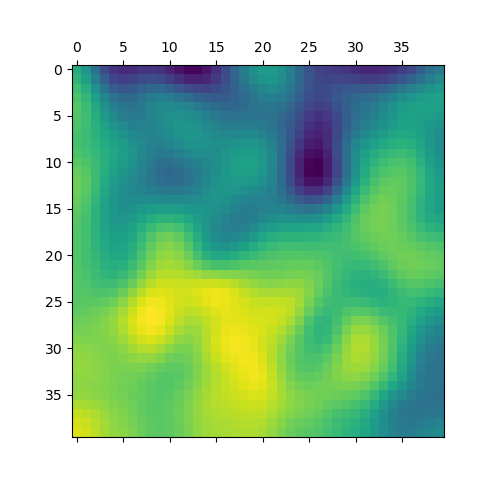

In [432]:
plt.matshow(ratemap_wo_nan, aspect='auto')
plt.show()

<IPython.core.display.Javascript object>


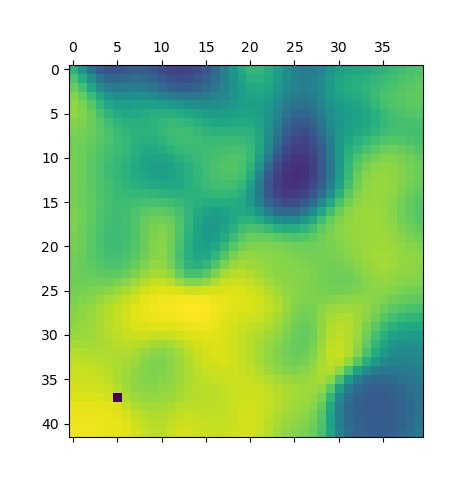

In [433]:
plt.matshow(original_rm, aspect='auto')
plt.show()

In [336]:
(row.firing_times / 30000)

array([3.26666667e-03, 2.73666667e-02, 7.27333333e-02, ...,
       2.43819507e+03, 2.43821190e+03, 2.43822713e+03])

In [388]:
spike_times = np.zeros((len(traj_times)))
for i in range(0, len(actual_spike_times)):
    argmin = np.argmin(abs(traj_times - actual_spike_times[i]))
    spike_times[argmin] += 1

In [402]:
spike_times

array([0., 0., 0., ..., 0., 0., 0.])

<IPython.core.display.Javascript object>


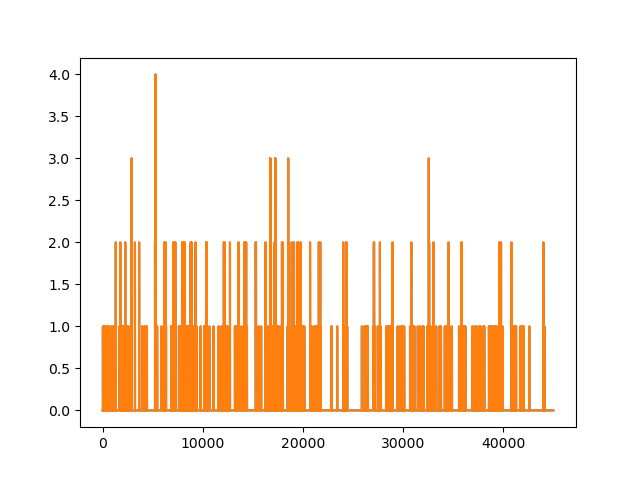

In [391]:
plt.plot(spike_times)
plt.show()

In [403]:
cc = np.bincount(np.arange(0, len(traj_times)), weights=actual_spike_times)

ValueError: The weights and list don't have the same length.

In [413]:
dd = np.interp(actual_spike_times, traj_times, np.arange(0, len(traj_times)))

In [414]:
plt.plot(dd)
plt.show()

<IPython.core.display.Javascript object>

In [416]:
dd = np.bincount(dd.astype(int))

In [360]:
spike_times = np.zeros((len(traj_times)))
for i in range(0, len(actual_spike_times)):
    argmin = np.argmin(abs(traj_times - actual_spike_times[i]))
    spike_times[argmin] += 1

array([2025.81056053, 2025.83466053, 2025.8800272 , 2025.91256053,
       2025.94386053, 2025.97729387, 2026.0124272 , 2026.0335272 ,
       2026.04806053, 2026.06916053, 2026.0886272 , 2026.10009387,
       2026.11499387, 2026.1602272 , 2026.22369387, 2026.24306053,
       2026.27156053, 2026.29189387, 2026.32729387, 2026.34209387,
       2026.38366053, 2026.46799387, 2026.49566053, 2026.60299387,
       2026.63406053, 2026.72069387, 2026.75276053, 2026.81239387,
       2026.8317272 , 2026.86209387, 2026.8781272 , 2026.89506053,
       2026.9156272 , 2026.9483272 , 2027.02496053, 2027.04699387,
       2027.52359387, 2027.5482272 , 2027.6274272 , 2027.65679387,
       2027.69239387, 2027.73079387, 2027.7773272 , 2027.8018272 ,
       2027.84979387, 2027.97759387, 2028.01399387, 2028.04939387,
       2028.09916053, 2028.1748272 , 2028.25409387, 2028.2944272 ,
       2028.31166053, 2028.4121272 , 2028.4251272 , 2028.44646053,
       2028.48246053, 2028.52419387, 2028.54079387, 2028.54829

In [424]:
dd.shape

(44097,)

In [426]:
np.pad(dd, (0, len(traj_times) - len(dd))).shape

(45001,)

In [427]:
traj_times.shape

(45001,)

<IPython.core.display.Javascript object>


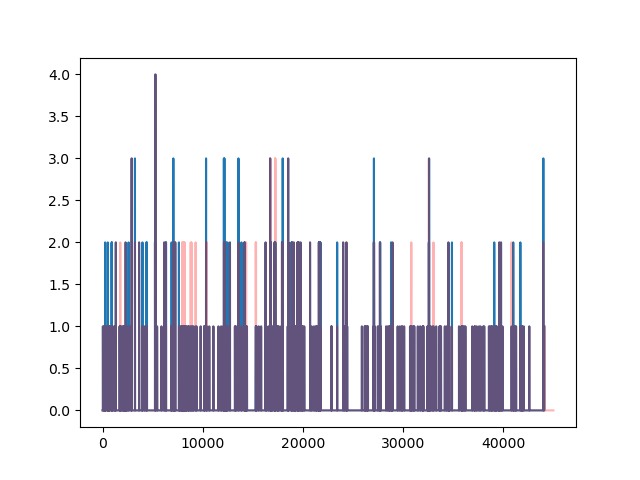

In [423]:
plt.plot(dd)
plt.plot(spike_times, 'r', alpha=0.3)
plt.show()

In [235]:
traj_times[0:100]

array([0.00593333, 0.03804853, 0.07027893, 0.10177973, 0.13326773,
       0.16512693, 0.19716533, 0.22975413, 0.26154933, 0.29340853,
       0.34192053, 0.37369013, 0.40561333, 0.43806133, 0.46951093,
       0.50207413, 0.53384373, 0.56576693, 0.59748533, 0.62954933,
       0.66166453, 0.69329333, 0.72567733, 0.77411253, 0.80537013,
       0.83806133, 0.87004853, 0.90116533, 0.93383093, 0.96501173,
       0.99745973, 1.02942133, 1.06171573, 1.09325493, 1.12580533,
       1.15730613, 1.20530613, 1.23753653, 1.26970293, 1.30193333,
       1.33352373, 1.36542133, 1.39783093, 1.42934453, 1.46145973,
       1.49351093, 1.52917173, 1.55775413, 1.58969013, 1.63775413,
       1.66981813, 1.70207413, 1.73413813, 1.76597173, 1.79793333,
       1.82963893, 1.86171573, 1.89351093, 1.92576693, 1.95747253,
       1.98957493, 2.02121653, 2.06961333, 2.10186933, 2.13296053,
       2.16597173, 2.19757493, 2.22949813, 2.26162613, 2.29289653,
       2.32563893, 2.35789493, 2.38944693, 2.42148533, 2.45366

<IPython.core.display.Javascript object>


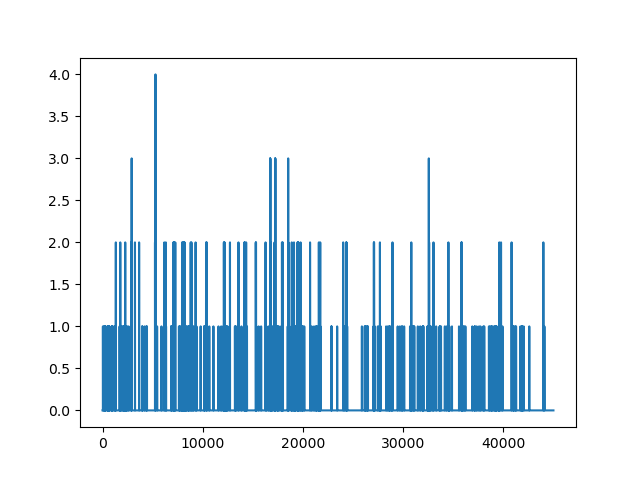

In [246]:
plt.plot(spike_times)
plt.show()

<ipython-input-447-9018f9ba0a66>:5: RuntimeWarning: Mean of empty slice
  axes[idx].matshow(np.nanmean(all_ratemaps, axis=0), aspect='auto')


<IPython.core.display.Javascript object>


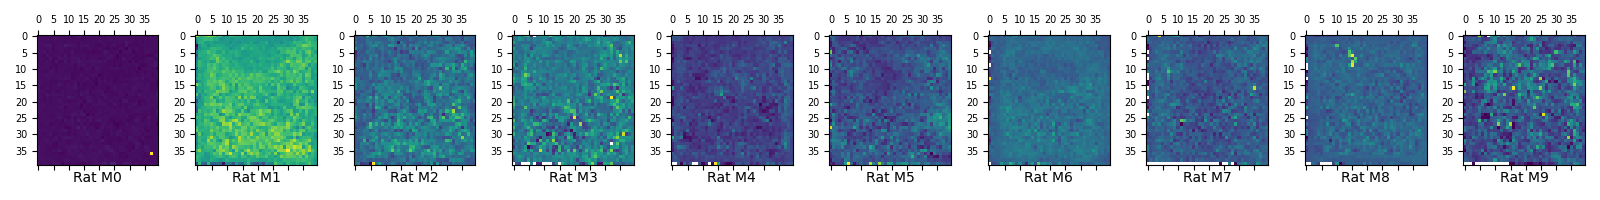

In [447]:
fig, axes = plt.subplots(1, len(by_rat), figsize=(16, 2))

for idx, (key,item) in enumerate(by_rat.items()):
    all_ratemaps = np.array(by_rat[key])
    axes[idx].matshow(np.nanmean(all_ratemaps, axis=0), aspect='auto')
    axes[idx].set_xlabel('Rat {}'.format(key))
for ax in axes:
    ax.grid(False)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(7)
    
fig.tight_layout()
fig.show()

In [102]:
all_ratemaps.shape

(7, 25, 25)

<IPython.core.display.Javascript object>


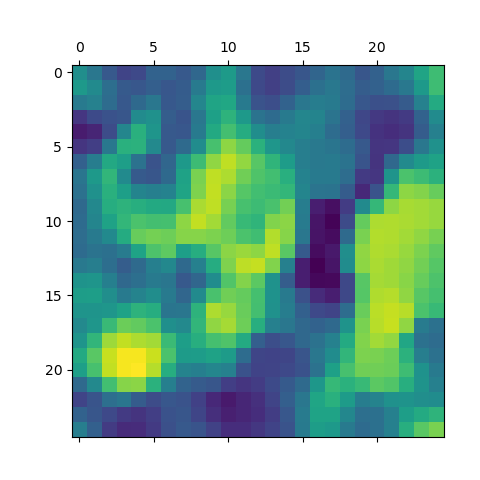

In [100]:
plt.matshow(ratemap_wo_nan, aspect='auto')
plt.show()

In [ ]:
data.shape

In [ ]:
plt.matshow(np.median(all_rm_padded, axis=0))
plt.show()

In [ ]:
plt.matshow(np.mean(all_rm_padded, axis=0))
plt.show()

In [ ]:
plt.matshow(all_rm[0], aspect='auto')
plt.show()

In [28]:
grid_scores = []
for rmp in all_rm:
    S = SAC()
    basic_ratemap = rmp
    nodwell = ~np.isfinite(basic_ratemap)
    sac = S.autoCorr2D(basic_ratemap, nodwell)
    measures = S.getMeasures(sac)
    
    grid_scores.append(measures['gridness'])
grid_scores = np.array(grid_scores)

/home/marx/miniconda3/envs/hackathon/lib/python3.8/site-packages/ephysiopy/common/ephys_generic.py:2207: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peaksMask = feature.peak_local_max(
/home/marx/miniconda3/envs/hackathon/lib/python3.8/site-packages/ephysiopy/common/binning.py:638: RuntimeWarning: divide by zero encountered in true_divide
  mapCovar / mapStd / mapStd[::-1, :, :][:, ::-1, :][:, :, :])


In [29]:
grid_scores = np.array(grid_scores)

In [48]:
np.sort(grid_scores)[::-1]

array([        nan,  1.25620437,  1.22843335,  1.2194121 ,  1.08379569,
        1.06042465,  1.03230045,  1.02426176,  1.02121211,  0.95858719,
        0.93461885,  0.92387484,  0.9054974 ,  0.89878319,  0.88378858,
        0.87023715,  0.86218571,  0.86017854,  0.85956124,  0.84968762,
        0.78423625,  0.77860372,  0.75512801,  0.74607261,  0.73654062,
        0.72635701,  0.71771038,  0.71202895,  0.68245305,  0.67882755,
        0.67371561,  0.67127271,  0.65242892,  0.64957703,  0.63858143,
        0.63373568,  0.62288104,  0.62180643,  0.61021726,  0.60465292,
        0.59508146,  0.58706567,  0.5747383 ,  0.56747911,  0.56714703,
        0.56176017,  0.55460683,  0.55431706,  0.50953042,  0.47819217,
        0.47657207,  0.46939906,  0.46499433,  0.46165063,  0.4476134 ,
        0.43710201,  0.42642226,  0.42528613,  0.42127316,  0.42118462,
        0.41095173,  0.4103567 ,  0.40596958,  0.40537139,  0.39571947,
        0.39450295,  0.39365852,  0.3847076 ,  0.37798725,  0.37

In [40]:
np.argsort(grid_scores)[::-1]

array([ 72,  74, 290, 298, 158, 122,  96, 284,  97, 179,  76, 302, 171,
       103, 102, 250, 264, 297, 227, 256, 294, 170, 286, 358, 166, 346,
       195, 237, 280, 228, 268, 253, 289,  95, 271,  23, 239, 130, 273,
       283,  99, 367, 197, 345, 269, 285, 230, 328,  40, 332, 291, 231,
       223, 168, 263, 353, 159, 295, 167, 127, 148, 317, 369, 110,  51,
       164,  28, 338,  78,  38, 160, 118, 326, 267, 311, 238,  12, 292,
       315, 131, 272, 296, 322, 252,  50, 329, 178, 135, 134, 144, 314,
       104, 255, 208, 163, 198, 299, 114,   2, 143, 115, 150, 261, 176,
       248, 105,  55, 182, 293,  61, 301, 305,  83, 213, 276, 172, 287,
       344, 259, 265, 117, 155,  11, 100, 190,  85, 142, 113, 235, 120,
       247,  22, 121, 324,  80, 153, 243, 333, 129, 245,  98, 125, 194,
       339, 154,   6,  36,  81,  89, 303, 186, 224, 236,  64, 109,  35,
       321, 251,  88, 220, 123, 169, 240, 364,  57,   8, 112,  30, 152,
       304, 215, 225, 343,  42,  17, 244, 363, 318, 183, 334,  8

<IPython.core.display.Javascript object>


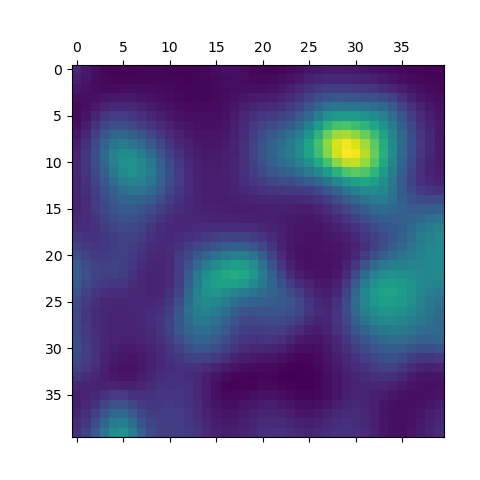

In [60]:
plt.matshow(all_rm_padded[237,:], aspect='auto')
plt.show()

In [34]:
grid_scores[74]

1.2562043672361953